In [2]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
from speechbrain.inference.interfaces import foreign_class
import sounddevice as sd
from collections import deque
import threading
import time
import torch.nn as nn
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_val):
        ctx.lambda_val = lambda_val
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_val, None

class GradientReversalLayer(nn.Module):
    def __init__(self, lambda_val=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_val = lambda_val

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_val)

class VGG19EmotionCNN(nn.Module):
    def __init__(self, num_classes, lambda_val=1.0):
        super(VGG19EmotionCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.dropout = nn.Dropout(0.1)
        self.grl = GradientReversalLayer(lambda_val)
        self.domain_classifier = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = self.dropout(nn.ReLU()(self.fc2(x)))
        emotion_output = self.fc3(x)
        domain_output = self.domain_classifier(self.grl(x))
        return emotion_output, domain_output


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


In [ ]:
## this code for testing on laptop camera
## if the code is lagging  change scaleFactor to high value maybe around 1.2 and to better accuracy reduce the scaleFactor to 1.05 
emotion_classes = ['angry', 'happy', 'neutral', 'sad', 'surprise']

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG19EmotionCNN(num_classes=len(emotion_classes))
checkpoint = torch.load('./modelsAll/DANN32.2_fine_tuned.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

frontal_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
profile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

classifier = foreign_class(
    source="speechbrain/emotion-recognition-wav2vec2-IEMOCAP",
    pymodule_file="custom_interface.py",
    classname="CustomEncoderWav2vec2Classifier",
    run_opts={"device": "cuda"} if torch.cuda.is_available() else {}
)

emotion_map = {
    "neu": "neutral",
    "hap": "happy",
    "sad": "sad",
    "ang": "angry",
    "exc": "excited",
    "sur": "surprise",
}

sample_rate = 16000
window_duration = 1
stride_duration = 0.25
window_samples = int(sample_rate * window_duration)
stride_samples = int(sample_rate * stride_duration)

audio_buffer = deque(maxlen=2 * window_samples)
voice_emotion_output = "Waiting..."
voice_update_interval = 1.0
last_voice_update = time.time()

def audio_callback(indata, frames, _, status):
    global voice_emotion_output, last_voice_update
    if status:
        print(status)
    audio_buffer.extend(indata[:, 0])

    if len(audio_buffer) >= window_samples and time.time() - last_voice_update > voice_update_interval:
        audio_tensor = torch.tensor(np.array(audio_buffer)).float().unsqueeze(0).to(device)
        _, _, _, text_lab = classifier.classify_batch(audio_tensor)
        emotion_abbr = text_lab[0]
        emotion_full = emotion_map.get(emotion_abbr, "Unknown")
        voice_emotion_output = f"{emotion_full}"
        for _ in range(stride_samples):
            audio_buffer.popleft()
        last_voice_update = time.time()

def audio_stream():
    with sd.InputStream(samplerate=sample_rate, channels=1, callback=audio_callback):
        while True:
            time.sleep(0.05)

audio_thread = threading.Thread(target=audio_stream, daemon=True)
audio_thread.start()

def non_max_suppression(boxes, overlap_thresh=0.5):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = areas.argsort()[::-1]
    suppressed = []
    while len(order) > 0:
        i = order[0]
        suppressed.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        inter_width = np.maximum(0, xx2 - xx1 + 1)
        inter_height = np.maximum(0, yy2 - yy1 + 1)
        inter_area = inter_width * inter_height
        union_area = areas[i] + areas[order[1:]] - inter_area
        iou = inter_area / union_area
        remain = np.where(iou <= overlap_thresh)[0]
        order = order[remain + 1]
    return boxes[suppressed].tolist()

def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    frontal_faces = frontal_cascade.detectMultiScale(
        gray, 
        scaleFactor=1.16, 
        minNeighbors=8, 
        minSize=(40, 40)
    )
    profile_faces = profile_cascade.detectMultiScale(
        gray, 
        scaleFactor=1.4, 
        minNeighbors=8, 
        minSize=(40, 40)
    )
    flipped_gray = cv2.flip(gray, 1)
    profile_faces_flipped = profile_cascade.detectMultiScale(
        flipped_gray, 
        scaleFactor=1.4, 
        minNeighbors=8, 
        minSize=(40, 40)
    )
    profile_faces_flipped = [(gray.shape[1] - x - w, y, w, h) for (x, y, w, h) in profile_faces_flipped]
    all_faces = list(frontal_faces) + list(profile_faces) + profile_faces_flipped
    return non_max_suppression(all_faces, overlap_thresh=0.4)

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    faces = detect_faces(frame)
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
        face_tensor = transform(face_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            emotion_outputs, _ = model(face_tensor)
            _, predicted = torch.max(emotion_outputs, dim=1)
            emotion = emotion_classes[predicted.item()]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(frame, f"Voice Emotion: {voice_emotion_output}", (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 1)
    cv2.imshow('Enhanced Face Detection and Emotion Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


C:\Users\Yahya\AppData\Local\Temp\ipykernel_11356\3631906676.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./modelsAll/DANN32.2_fine_tuned.pt

input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflowinput overflow
input overflow

input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input over

input overflow
input overflow
input overflow
input overflow
input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow

input overflow
input overflowinput overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input overflowinput overflow
input overflow

input over

C:\Users\Yahya\AppData\Local\Temp\ipykernel_15424\3181043478.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./modelsAll/DANN32.2_fine_tuned.pt

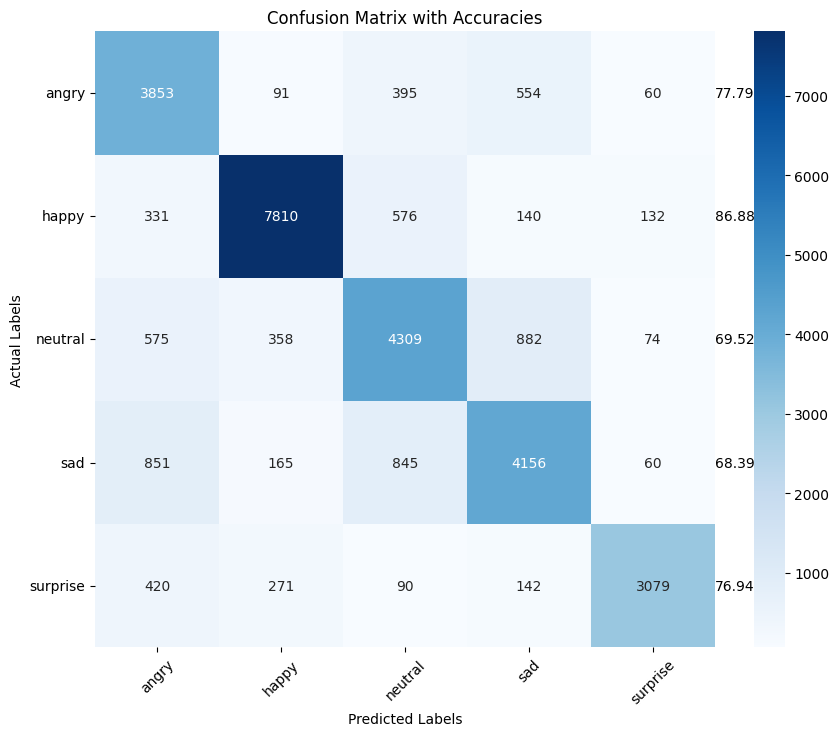


Class-wise Metrics:
angry: Precision=0.64, Recall=0.78, F1-Score=0.70, Accuracy=77.79%
happy: Precision=0.90, Recall=0.87, F1-Score=0.88, Accuracy=86.88%
neutral: Precision=0.69, Recall=0.70, F1-Score=0.69, Accuracy=69.52%
sad: Precision=0.71, Recall=0.68, F1-Score=0.70, Accuracy=68.39%
surprise: Precision=0.90, Recall=0.77, F1-Score=0.83, Accuracy=76.94%

Overall Accuracy: 76.80%


In [3]:
## this code for testing on dataset https://www.kaggle.com/datasets/chiragsoni/ferdata/data
## it calculates the confusion matrix and classification report

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn

emotion_classes = ['angry', 'happy', 'neutral', 'sad', 'surprise']

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_data_dir = './datasets/Testing-emotions/AllData/'
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG19EmotionCNN(num_classes=len(emotion_classes))
checkpoint = torch.load('./modelsAll/DANN32.2_fine_tuned.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        emotion_outputs, _ = model(images)
        _, predicted = torch.max(emotion_outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(len(emotion_classes)))

report = classification_report(all_labels, all_predictions, target_names=emotion_classes, output_dict=True)

class_accuracies = {}
for i, class_name in enumerate(emotion_classes):
    class_accuracies[class_name] = conf_matrix[i, i] / sum(conf_matrix[i]) * 100

def plot_confusion_matrix(conf_matrix, classes, class_accuracies):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix with Accuracies')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    for i, class_name in enumerate(classes):
        plt.text(len(classes), i + 0.5, f'{class_accuracies[class_name]:.2f}%', va='center', fontsize=10)
    plt.show()

plot_confusion_matrix(conf_matrix, emotion_classes, class_accuracies)

print("\nClass-wise Metrics:")
for class_name in emotion_classes:
    print(f"{class_name}: Precision={report[class_name]['precision']:.2f}, Recall={report[class_name]['recall']:.2f}, F1-Score={report[class_name]['f1-score']:.2f}, Accuracy={class_accuracies[class_name]:.2f}%")

overall_accuracy = report['accuracy'] * 100
print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")
